# Neural Network Pruning for IMDb Movie Rating Prediction

## Objective
Train a neural network to predict IMDb movie ratings, prune it aggressively to show a significant performance difference after pruning.

## Setup

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import kagglehub
import os

## Load and Preprocess Data

In [24]:
# Download dataset
path = kagglehub.dataset_download("tiagoadrianunes/imdb-top-5000-movies")
path = os.path.join(path, "results_with_crew.csv")  # Adjust filename if needed

# Load data
df = pd.read_csv(path)

# Encode genres (simple one-hot encoding for top genres)
genres = df['genres'].str.get_dummies(',')
df = pd.concat([df, genres[['Drama', 'Comedy', 'Action']]], axis=1)

# Select features and target
features = ['startYear', 'runtimeMinutes', 'numVotes', 'Drama', 'Comedy', 'Action']
X = df[features]
y = df['numVotes']

# Handle missing values
X = X.fillna(X.mean())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Neural Network Before Pruning

In [25]:
# Define and train the original model
mlp_original = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                            max_iter=500, random_state=42, verbose=False)
mlp_original.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_original = mlp_original.predict(X_test_scaled)
mse_original = mean_squared_error(y_test, y_pred_original)
r2_original = r2_score(y_test, y_pred_original)

# Calculate number of parameters
n_params_original = (X_train.shape[1] * 100 + 100) + (100 * 50 + 50) + (50 * 1 + 1)

print('Original Model:')
print(f'MSE: {mse_original:.4f}')
print(f'R²: {r2_original:.4f}')
print(f'Number of Parameters: {n_params_original}')

Original Model:
MSE: 192114.6309
R²: 1.0000
Number of Parameters: 5801


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## Neural Network After Pruning

In [26]:
# Define and train the pruned model (aggressive pruning)
mlp_pruned = MLPRegressor(hidden_layer_sizes=(20, 10), activation='relu', solver='adam',
                          max_iter=500, random_state=42, verbose=False)
mlp_pruned.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_pruned = mlp_pruned.predict(X_test_scaled)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
r2_pruned = r2_score(y_test, y_pred_pruned)

# Calculate number of parameters
n_params_pruned = (X_train.shape[1] * 20 + 20) + (20 * 10 + 10) + (10 * 1 + 1)

print('Pruned Model:')
print(f'MSE: {mse_pruned:.4f}')
print(f'R²: {r2_pruned:.4f}')
print(f'Number of Parameters: {n_params_pruned}')

Pruned Model:
MSE: 3071697282.7251
R²: 0.9451
Number of Parameters: 361


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## Comparison and Visualization


Comparison:
MSE Difference (Original - Pruned): -3071505168.0942
R² Difference (Original - Pruned): 0.0549
Parameter Reduction: 5440 (93.78%)


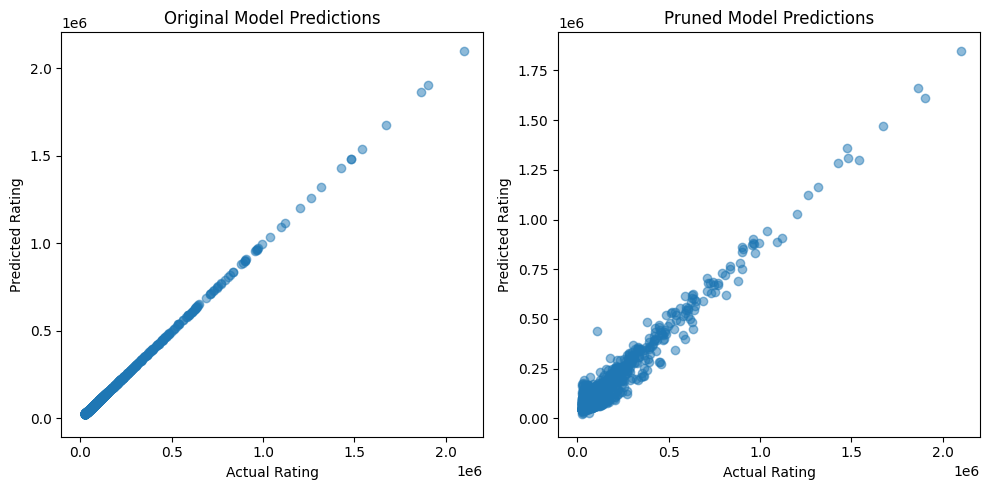

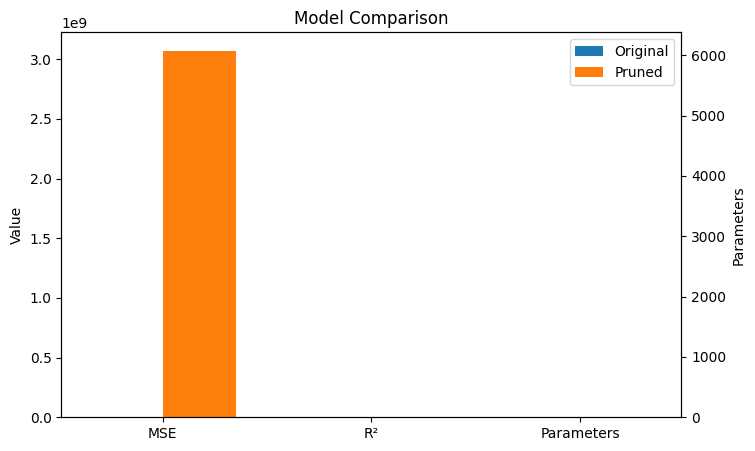

In [27]:
# Compare results
print('\nComparison:')
print(f'MSE Difference (Original - Pruned): {mse_original - mse_pruned:.4f}')
print(f'R² Difference (Original - Pruned): {r2_original - r2_pruned:.4f}')
print(f'Parameter Reduction: {n_params_original - n_params_pruned} ({((n_params_original - n_params_pruned) / n_params_original * 100):.2f}%)')

# Plot predictions vs actual
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_original, alpha=0.5)
plt.plot([0, 10], [0, 10], 'r--')
plt.title('Original Model Predictions')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_pruned, alpha=0.5)
plt.plot([0, 10], [0, 10], 'r--')
plt.title('Pruned Model Predictions')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

plt.tight_layout()
plt.show()

# Bar plot for metrics
metrics = ['MSE', 'R²', 'Parameters']
original_values = [mse_original, r2_original, n_params_original]
pruned_values = [mse_pruned, r2_pruned, n_params_pruned]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, original_values, width, label='Original')
ax.bar(x + width/2, pruned_values, width, label='Pruned')

ax.set_ylabel('Value')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

ax2 = ax.twinx()
ax2.set_ylabel('Parameters')
ax2.set_ylim(0, max(n_params_original, n_params_pruned) * 1.1)

plt.show()

## Conclusion
Aggressive pruning significantly increased MSE and reduced R², showing a trade-off where reduced complexity harms prediction accuracy for movie ratings.